In [114]:
import pickle
import matplotlib.pyplot as plt
pickle_in = open("dataset_pickle\X_user.pickle","rb")
X = pickle.load(pickle_in)

X = X/255.0

pickle_in = open("dataset_pickle\y_user.pickle","rb")
y = pickle.load(pickle_in)

In [115]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [122]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)



In [133]:
#Double dataset with Gaussian Noise
from tensorflow.keras.layers import GaussianNoise
import tensorflow_addons as tfa


sample = GaussianNoise(0.01)
# sample2 = GaussianNoise(0.1)
#x_train = sample(x_train,training = True)
#x_test = sample(x_test,training = True)


In [129]:
#plt.imshow(noise_test[5])

In [130]:
#Setup Distrbuited training
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())   #Enables

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


AxesImage(54,36;334.8x217.44)
#############################
AxesImage(54,36;334.8x217.44)


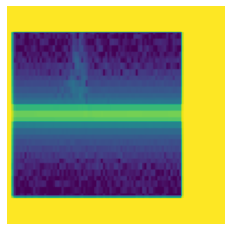

In [149]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from sklearn.model_selection import StratifiedKFold #for K-fold cross validation
import numpy

tf.random.set_seed(42)

Resolution = 100

# numpy.random.seed(7)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
cvscores = []

#for train, test in kfold.split(X, y):
data_augmentation = Sequential(
  [
#     GaussianNoise(0.01, input_shape =(Resolution,Resolution,1))
    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0, width_factor=0.1)
    # layers.experimental.preprocessing.RandomFlip("horizontal", 
    #        input_shape=( 180,  180,  1)),
    # layers.experimental.preprocessing.RandomRotation(0.1),
    # layers.experimental.preprocessing.RandomZoom(0.1),
    
  ])
plt.axis('off')
print(plt.imshow(X[5]))

print("#############################")
# plt.axis('off')
print(plt.imshow(data_augmentation(X)[5].numpy()))#.astype("uint8")))

with strategy.scope():      #Enables multi-gpu
    model = Sequential([
        data_augmentation,
        Conv2D(filters=32, kernel_size=(3, 3), padding="same" ,activation='relu', input_shape=(Resolution, Resolution, 1)),
        MaxPooling2D(pool_size=(1, 5), strides=(4)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 4), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2)),

        Conv2D(filters=32, kernel_size=(3, 3),padding="same" , activation='relu'),
        MaxPooling2D(pool_size=(1, 2), strides=(2)),
        
        Flatten(),
        #Dense(32, activation='relu'),

        Dense(6, activation='softmax')
    ])
# model.summary()
    
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),                  #gradient descent
              metrics=['accuracy'])

#model.build((None, X.shape[1], X.shape[2], X.shape[3]))
lr_change = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.000)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='min')
callbacks = [lr_change,early_stopping]

            

# lr_change = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=0.000)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=10, mode='min')
# callbacks = [lr_change,early_stopping]
    #scores = model.evaluate(X[test], y[test], verbose=0)
    #print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    #cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))    

In [150]:
history = model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test),callbacks=callbacks)

Epoch 1/200


UnknownError: 3 root error(s) found.
  (0) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_79/conv2d_220/Conv2D (defined at \threading.py:932) ]]
  (1) Cancelled:  Function was cancelled before it was started
  (2) Unknown:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_79/conv2d_220/Conv2D (defined at \threading.py:932) ]]
	 [[Adam/AddN/_72]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_40100]

Function call stack:
train_function -> train_function -> train_function


In [95]:
#history = model.fit(X, y, batch_size=16, epochs=200, validation_split=0.2,callbacks=callbacks)



In [96]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X,  y, verbose=2)
preds = model.evaluate(X, y,verbose=1, sample_weight=None)

NameError: name 'history' is not defined

In [53]:
model.save("models\model_habd2.h5")
print("model saved")

ValueError: Weights for model sequential_7 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [54]:
from keras.models import load_model
# load model
model = load_model('models\model_habd.h5')

In [55]:
# evaluate the model
import pickle
pickle_in = open("dataset_pickle\X_user.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("dataset_pickle\y_user.pickle","rb")
y_test = pickle.load(pickle_in)

X_test = X_test/255.0

score = model.evaluate(X_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_6/conv2d_26/Conv2D (defined at <ipython-input-55-1a0673d84104>:11) ]] [Op:__inference_test_function_930]

Function call stack:
test_function
